In [2]:
import numpy as np

In [3]:
from load import WESAD
wesad = WESAD()

Finished building DataFrame


<Figure size 1000x600 with 0 Axes>

In [4]:
700 * 60 * 5 # 5min

210000

In [5]:
wesad.group_df

,ACC_0,ACC_1,ACC_2,ECG,EMG,EDA,Resp,Temp
0,0.7146,-0.4786,-0.4466,-0.054382,0.005356,1.292801,1.972961,32.821808
1,0.9182,-0.0254,0.0754,-0.055756,0.000595,2.369690,2.461243,33.462799
2,0.6082,-0.0594,-0.7290,0.027145,-0.005951,1.285934,2.052307,28.142120
3,0.8226,-0.1502,-0.4358,0.026321,-0.008881,3.768539,2.642822,34.966431
4,0.7534,-0.0514,-0.5638,-0.451721,0.003983,2.818680,1.780701,33.759552
5,0.9106,-0.0910,-0.1508,1.223831,0.013412,3.374100,1.045227,33.668579
6,0.8680,0.0470,0.3368,-0.292740,-0.005630,3.545380,-1.698303,34.600220
7,0.9144,0.0670,0.0792,1.499130,-0.032455,8.365250,-2.641296,33.561066
8,0.8952,0.0544,0.1154,-0.060013,-0.006638,3.498077,10.688782,34.557251
9,0.9064,0.0294,0.0202,-0.065002,-0.061844,8.704376,-4.017639,31.946991


# 資料特徵工程

## ECG

On the raw ECG/BVP signal the heart beats were found based on peak detection algorithms. 

Using the peaks, the heart rate (HR) and corresponding statistical features (mean, standard deviation) were computed. 


Moreover, from the location of the heart beats the heart rate variablility (HRV) was derived, which is an important starting
point for additional features. 

> 這是來自 WESAD 資料集論文的內容，請確切解釋上面段落的含意，並附上相關的python實作計算 HR 與 HRV

For instance, the energy in different frequency bands (f x
HRV ) was computed. 

The frequency bands (x)
used, were the ultra low (ULF: 0.01-0.04 Hz), low (LF: 0.04-0.15 Hz),
high (HF: 0.15-0.4 Hz) and ultra high (UHF: 0.4-1.0 Hz) band. 

In [15]
the HR and HRV are described in detail.


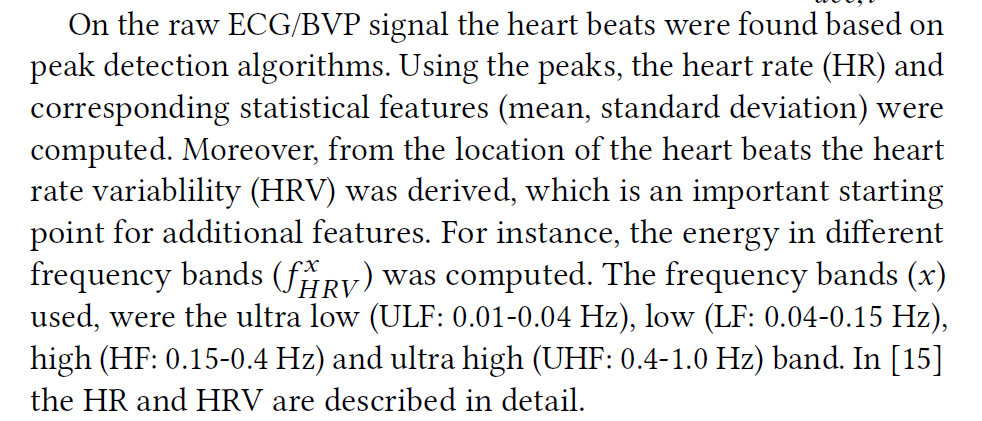

#### ECG 延伸信號
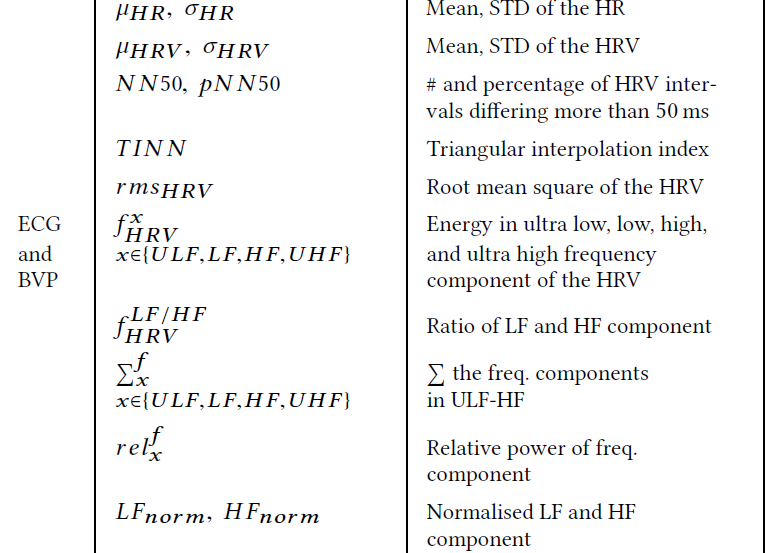

- R 波 (10~30HZ)
- P 波 (0.5~10HZ)
- T 波 (0.1~5HZ)

我目前只有ECG信號，實現以下特徵提取方法


$f^{x}_{HRV} \\{x \in \{ULF,LF,HF,UHF\}}$


Energy in ultra low,low,high,and ultra high frequency component of HRV


HRV Frequency Domain Features:
ULF: 0.000000
VLF: 0.000000
LF: 0.409538
HF: 0.018842
UHF: 0.000007
ULF_normalized: 0.000000
VLF_normalized: 0.000000
LF_normalized: 0.956001
HF_normalized: 0.043983
UHF_normalized: 0.000016
LF_HF_ratio: 21.735446


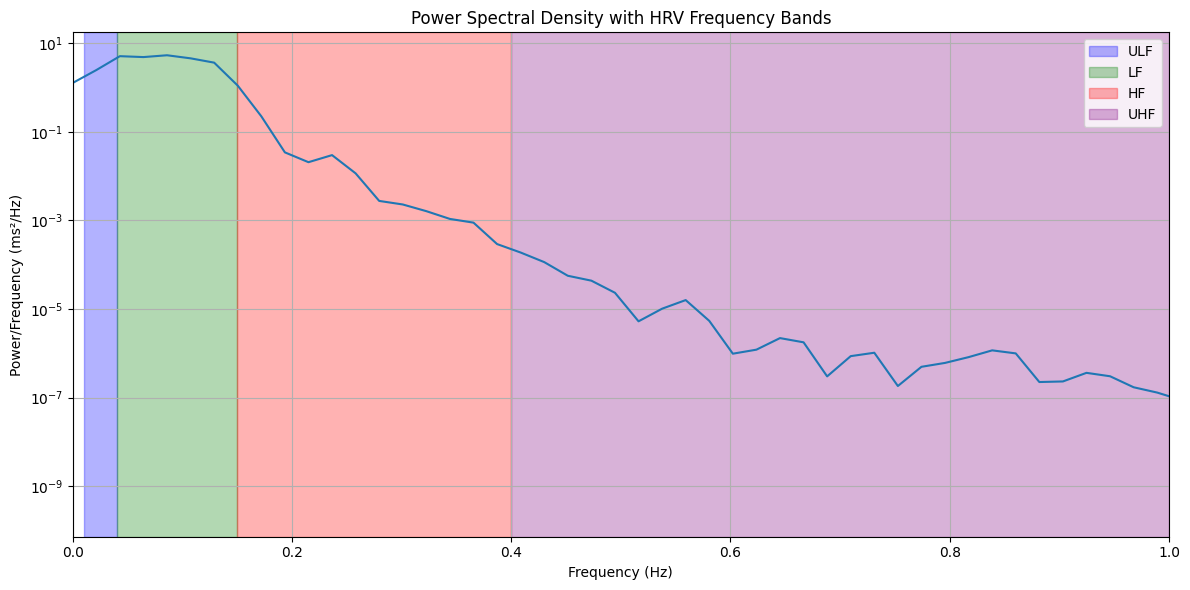

In [6]:
import numpy as np
import scipy.signal as signal
from scipy import interpolate
import matplotlib.pyplot as plt
import neurokit2 as nk  # Optional, for easier ECG processing

def extract_hrv_frequency_features(ecg_signal, sampling_rate=250):
    """
    Extract frequency domain HRV features from ECG signal
    
    Parameters:
    -----------
    ecg_signal : np.array
        The raw ECG signal
    sampling_rate : int
        Sampling rate of the ECG signal in Hz
        
    Returns:
    --------
    dict
        Dictionary containing ULF, VLF, LF, HF, and UHF energy components
    """
    
    # Step 1: ECG processing - R-peak detection
    # You can use a library like neurokit2 or implement your own
    # Using neurokit2 (if available):
    try:
        _, info = nk.ecg_process(ecg_signal, sampling_rate=sampling_rate)
        rpeaks = info['ECG_R_Peaks']  # Indices of R-peaks
    except:
        # Alternative: Use your own R-peak detection algorithm
        # For example, using scipy.signal.find_peaks with appropriate parameters
        ecg_filtered = bandpass_filter(ecg_signal, lowcut=5, highcut=15, fs=sampling_rate)
        rpeaks, _ = signal.find_peaks(ecg_filtered, height=0.5*np.max(ecg_filtered), distance=0.5*sampling_rate)
    
    # Step 2: Calculate RR intervals in seconds
    rr_intervals = np.diff(rpeaks) / sampling_rate
    
    # Optional: Remove outliers (ectopic beats)
    # rr_intervals = remove_outliers(rr_intervals)
    
    # Step 3: Interpolate to create evenly sampled signal
    # Interpolation frequency (typically 4 Hz for HRV analysis)
    fs_interp = 4.0
    
    # Create time array (cumulative sum of RR intervals)
    time_rr = np.cumsum(rr_intervals)
    time_rr = np.insert(time_rr, 0, 0)  # Insert 0 at beginning
    
    # Create evenly spaced time array for interpolation
    time_interp = np.arange(0, time_rr[-1], 1/fs_interp)
    
    # Interpolate RR intervals
    tck = interpolate.splrep(time_rr[:-1], rr_intervals, s=0)
    rr_interpolated = interpolate.splev(time_interp, tck, der=0)
    
    # Step 4: Detrend the interpolated RR intervals
    rr_detrended = signal.detrend(rr_interpolated)
    
    # Step 5: Apply windowing (e.g., Hann window)
    window = signal.windows.hann(len(rr_detrended))
    rr_windowed = rr_detrended * window
    
    # Step 6: Compute power spectral density using Welch's method
    # Using Welch's method for better frequency resolution
    freqs, psd = signal.welch(rr_windowed, fs=fs_interp, nperseg=len(rr_windowed)//2, 
                            scaling='density', detrend=False)
    
    # Step 7: Calculate energy in frequency bands
    freq_bands = {
        'ULF': (0.0, 0.003),     # Ultra low frequency
        'VLF': (0.003, 0.04),    # Very low frequency
        'LF': (0.04, 0.15),      # Low frequency
        'HF': (0.15, 0.4),       # High frequency
        'UHF': (0.4, 0.5)        # Ultra high frequency (sometimes not used in standard HRV)
    }
    
    # Calculate energy in each band
    energies = {}
    for band_name, (low_freq, high_freq) in freq_bands.items():
        # Find indices corresponding to the frequency band
        indices = np.logical_and(freqs >= low_freq, freqs <= high_freq)
        # Calculate energy (area under the PSD curve) in the band
        band_energy = np.trapz(psd[indices], freqs[indices])
        energies[band_name] = band_energy
    
    # Calculate total power
    total_power = np.sum(list(energies.values()))
    
    # Calculate normalized powers and add to dictionary
    # 修正：使用原始字典的副本進行迭代，避免在迭代時修改字典
    for band in list(energies.keys()):
        energies[f"{band}_normalized"] = energies[band] / total_power
    
    # Add LF/HF ratio
    energies['LF_HF_ratio'] = energies['LF'] / energies['HF'] if energies['HF'] > 0 else np.nan
    
    return energies, freqs, psd

def bandpass_filter(signal_data, lowcut, highcut, fs, order=5):
    """Apply Butterworth bandpass filter to signal"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, signal_data)

def remove_outliers(rr_intervals, threshold=0.2):
    """
    Remove outliers from RR intervals
    
    Parameters:
    -----------
    rr_intervals : np.array
        Array of RR intervals
    threshold : float
        Threshold for outlier detection (% of median)
    
    Returns:
    --------
    np.array
        RR intervals with outliers removed
    """
    median_rr = np.median(rr_intervals)
    
    # Identify outliers
    upper_limit = median_rr * (1 + threshold)
    lower_limit = median_rr * (1 - threshold)
    
    # Create mask for non-outliers
    mask = (rr_intervals >= lower_limit) & (rr_intervals <= upper_limit)
    
    return rr_intervals[mask]

def plot_psd_with_bands(freqs, psd, freq_bands):
    """Plot power spectral density with frequency bands highlighted"""
    plt.figure(figsize=(12, 6))
    plt.semilogy(freqs, psd)
    
    colors = ['blue', 'green', 'red', 'purple', 'orange']
    
    for (i, (band, (low, high))) in enumerate(freq_bands.items()):
        plt.axvspan(low, high, color=colors[i % len(colors)], alpha=0.3, label=band)
    
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (ms²/Hz)')
    plt.title('Power Spectral Density with HRV Frequency Bands')
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 1)
    plt.tight_layout()
    
    return plt

# Example usage
if __name__ == "__main__":
    # Load your ECG signal here
    # ecg_signal = load_ecg_data(...)
    
    ecg_signal = wesad.df[['ECG']][:700 * 60 * 5].to_numpy().flatten()
    
    # Extract HRV frequency features
    hrv_features, freqs, psd = extract_hrv_frequency_features(ecg_signal, sampling_rate=75)
    
    # Print results
    print("HRV Frequency Domain Features:")
    for feature, value in hrv_features.items():
        print(f"{feature}: {value:.6f}")
    
    # Plot PSD with frequency bands
    # ULF, LF, HF, UHF => [[0.01, 0.04], [0.04, 0.15], [0.15, 0.4], [0.4, 1.0]]
    freq_bands = {
        'ULF': (0.01, 0.04),
        'LF': (0.04, 0.15),
        'HF': (0.15, 0.4),
        'UHF': (0.4, 1.0)
    }
    
    plot = plot_psd_with_bands(freqs, psd, freq_bands)
    plot.show()

In [7]:
# 從多個受試者/情況提取特徵
all_features = []
all_labels = []

ecg_signal = wesad.df[['ECG']][:700 * 60 * 5].to_numpy().flatten()

# 提取HRV頻域特徵
hrv_features, _, _ = extract_hrv_frequency_features(ecg_signal, sampling_rate=250)

# 只選擇感興趣的特徵
selected_features = [
    hrv_features['ULF'], 
    hrv_features['LF'], 
    hrv_features['HF'],
    hrv_features['UHF'],
    hrv_features['LF_HF_ratio']  # 常用的衍生特徵
]

all_features.append(selected_features)
# all_labels.append(label)

# 轉換為numpy數組
X = np.array(all_features)
X
# y = np.array(all_labels)

array([[0.00000000e+00, 7.41176210e-02, 1.65681429e-02, 1.04895746e-03,
        4.47350205e+00]])

### 一些專有名詞

#### R 峰（ECG）

通過 峰值偵測演算法（如 Pan-Tompkins 或簡單的閥值法）從 ECG 信號取得

#### 脈搏峰（BVP）

通過 峰值偵測演算法（如 Pan-Tompkins 或簡單的閥值法）從 BVP 信號取得
#### 心跳數 (Heartbeats)

> 定義: 指的是一定時間內心臟跳動的總次數，單位: 次數 (beats)
> e.g. 心臟在過去 10 秒內跳了 15 次


#### 心率 (HR, Heart Rate)

> 定義: 指的是每分鐘（per minute）的心跳數，單位: bpm (beats per minute)

> 實作: 根據峰值的出現時間，計算兩個相鄰心跳之間的間隔（RR 間隔）
#### 心率變異性 (HRV, Heart Rate Variability)

> 定義: HRV 是 相鄰心跳（RR 間隔）的變化程度，代表自主神經系統（ANS）調控心率的能力。它可以用 時域分析 或 頻域分析 來描述。

> 實作

(A) 時域分析

    計算 RR 間隔的統計變異性：
        SDNN（標準差）：RR 間隔的標準差，反映整體變異性
        RMSSD（均方根差）：連續 RR 間隔變化的均方根，反映副交感神經活動
        pNN50（50ms 差異佔比）：連續 RR 間隔相差超過 50ms 的比例
        ➡ 這些都是基於 RR 間隔的時域特徵

(B) 頻域分析

    計算 RR 間隔的功率譜（PSD），分析不同頻率範圍的變化：
        LF（0.04–0.15 Hz）：交感+副交感神經
        HF（0.15–0.4 Hz）：副交感神經（呼吸性竇性心律變異, RSA）
        LF/HF 比值：交感/副交感平衡

由 RR 間隔換算每分鐘心跳數（bpm）>> 心跳數跟心率的差異是?

### Q: 已知ECG如何求得HR?
1. 預處理原始信號 (e.g. 降躁)
   1. 帶通濾波
   2. 歸一化
   3. 去除異常信號
2. 峰值檢測 (Peak Detectioin)
   1. ECG 信号的 R 波检测 >>> 請詳細介紹R波，給出具體的實作細節

In [26]:
fs = 700 * 60 * 5 //10
ecg_signal = wesad.df[['ECG']][:700 * 60 * 5].to_numpy().flatten()
print(ecg_signal.shape)

(210000,)


In [27]:
t = np.linspace(0, 10, fs * 10)  # 10 秒的信號

<class 'numpy.ndarray'>
[0.81871818 0.77324178 0.50133572 0.60938385 0.64566974 0.96857604
 0.80624193 0.53847875 0.50366907 0.55643122 0.75619408 0.64990786
 0.53133586 0.5343835 ]
HR 平均值: 95.25 bpm
HR 標準差: 18.52 bpm
HRV - SDNN: 139.91 ms
HRV - RMSSD: 166.54 ms
HRV - PNN50: 64.29 %


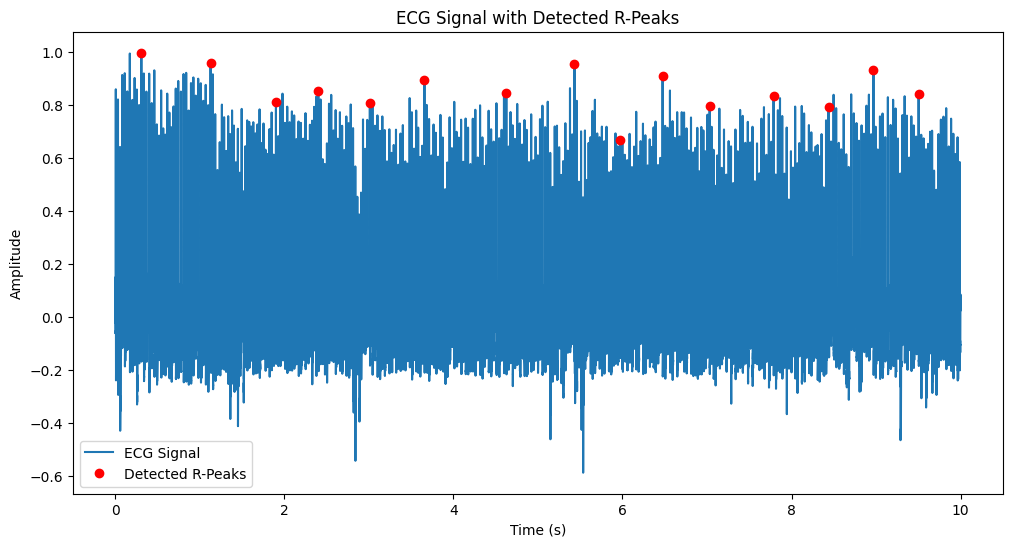

In [28]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

"""
# 模擬 ECG 信號
fs = 250  # 取樣率 (Hz)
t = np.linspace(0, 10, fs * 10)  # 10 秒的信號
ecg_signal = np.sin(2 * np.pi * 1.2 * t) + 0.5 * np.random.randn(len(t))  # 模擬心跳
"""

# 偵測 R 峰（這裡用簡單的峰值偵測）
peaks, _ = signal.find_peaks(ecg_signal, distance=fs//2, height=0.5)  # 假設 60-120 bpm
r_peaks_time = t[peaks]  # 峰值時間點

# 計算 RR 間隔
rr_intervals = np.diff(r_peaks_time)  # 以秒為單位的 RR 間隔

print(type(rr_intervals))
print(rr_intervals)
# print(f"RR Intervals: {rr_intervals:.2f}")
hr = 60 / rr_intervals  # 換算為 BPM

# 計算 HR 統計值
hr_mean = np.mean(hr)
hr_std = np.std(hr)

# 計算 HRV 相關指標
sdnn = np.std(rr_intervals)  # SDNN (ms)
rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))  # RMSSD (ms)
pnn50 = np.sum(np.abs(np.diff(rr_intervals)) > 0.05) / len(rr_intervals) * 100  # PNN50 (%)

# 顯示結果
print(f"HR 平均值: {hr_mean:.2f} bpm")
print(f"HR 標準差: {hr_std:.2f} bpm")
print(f"HRV - SDNN: {sdnn*1000:.2f} ms")
print(f"HRV - RMSSD: {rmssd*1000:.2f} ms")
print(f"HRV - PNN50: {pnn50:.2f} %")

# 繪圖
plt.figure(figsize=(12, 6))
plt.plot(t, ecg_signal, label="ECG Signal")
plt.plot(r_peaks_time, ecg_signal[peaks], "ro", label="Detected R-Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("ECG Signal with Detected R-Peaks")
plt.show()
